In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.robust.norms import HuberT
from skbio.stats.composition import ilr,clr,alr
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
family = pd.DataFrame(pd.read_csv("./food.csv"))
family = family.dropna()
family.head()

,Category,Description,Nutrient Data Bank Number,Data.Alpha Carotene,Data.Beta Carotene,Data.Beta Cryptoxanthin,Data.Carbohydrate,Data.Cholesterol,Data.Choline,Data.Fiber,...,Data.Major Minerals.Phosphorus,Data.Major Minerals.Potassium,Data.Major Minerals.Sodium,Data.Major Minerals.Zinc,Data.Vitamins.Vitamin A - RAE,Data.Vitamins.Vitamin B12,Data.Vitamins.Vitamin B6,Data.Vitamins.Vitamin C,Data.Vitamins.Vitamin E,Data.Vitamins.Vitamin K
0,Milk,"Milk, human",11000000,0,7,0,6.89,14,16.0,0.0,...,14,51,17,0.17,61,0.05,0.011,5.0,0.08,0.3
1,Milk,"Milk, NFS",11100000,0,4,0,4.87,8,17.9,0.0,...,103,157,39,0.42,59,0.56,0.060,0.1,0.03,0.2
2,Milk,"Milk, whole",11111000,0,7,0,4.67,12,17.8,0.0,...,101,150,38,0.41,32,0.54,0.061,0.0,0.05,0.3
3,Milk,"Milk, low sodium, whole",11111100,0,7,0,4.46,14,16.0,0.0,...,86,253,3,0.38,29,0.36,0.034,0.9,0.08,0.3
4,Milk,"Milk, calcium fortified, whole",11111150,0,7,0,4.67,12,17.8,0.0,...,101,150,38,0.41,32,0.54,0.061,0.0,0.05,0.3


In [11]:
compositional_cols = ['Data.Major Minerals.Calcium','Data.Major Minerals.Copper','Data.Major Minerals.Iron','Data.Major Minerals.Magnesium','Data.Major Minerals.Phosphorus','Data.Major Minerals.Potassium','Data.Major Minerals.Sodium','Data.Major Minerals.Zinc']

family = family[['Data.Major Minerals.Calcium','Data.Major Minerals.Copper','Data.Major Minerals.Iron','Data.Major Minerals.Magnesium','Data.Major Minerals.Phosphorus','Data.Major Minerals.Potassium','Data.Major Minerals.Sodium','Data.Major Minerals.Zinc','Data.Protein']]

family = family[(family != 0).all(axis=1)]
total_household_income = family['Data.Protein']
# Tách dữ liệu thành phần và biến mục tiêu
compositional_data = family[compositional_cols]
compositional_data = compositional_data.div(compositional_data.sum(axis=1), axis=0)
compositional_data.head()

,Data.Major Minerals.Calcium,Data.Major Minerals.Copper,Data.Major Minerals.Iron,Data.Major Minerals.Magnesium,Data.Major Minerals.Phosphorus,Data.Major Minerals.Potassium,Data.Major Minerals.Sodium,Data.Major Minerals.Zinc
0,0.272916,0.000443,0.000256,0.025586,0.119401,0.434961,0.144987,0.001450
3,0.225225,0.000022,0.000111,0.011150,0.191776,0.564178,0.006690,0.000847
6,0.381700,0.000021,0.000075,0.020582,0.188979,0.310599,0.097296,0.000748
16,0.225033,0.000021,0.000097,0.021339,0.172654,0.292930,0.287110,0.000815
17,0.225033,0.000021,0.000097,0.021339,0.172654,0.292930,0.287110,0.000815


In [12]:
# Thay thế các giá trị bằng 0 bằng một epsilon nhỏ
epsilon = 1e-9
compositional_data = compositional_data.replace(0, epsilon)

# Chuyển đổi dữ liệu thành phần bằng centered log-ratio (CLR)
clr_compositional_data = ilr(compositional_data)

# Chuyển dữ liệu CLR về dạng DataFrame để tiện sử dụng
clr_compositional_data = pd.DataFrame(clr_compositional_data)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(clr_compositional_data, total_household_income, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Thêm cột hằng số vào X_train và X_test cho mô hình hồi quy
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Tạo mô hình hồi quy mạnh mẽ (RLM) với chuẩn Huber
rlm_model = sm.RLM(y_train, X_train_scaled, M=HuberT())
rlm_results = rlm_model.fit()

# In kết quả mô hình
print(rlm_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:           Data.Protein   No. Observations:                 5290
Model:                            RLM   Df Residuals:                     5282
Method:                          IRLS   Df Model:                            7
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 01 Jun 2024                                         
Time:                        01:45:33                                         
No. Iterations:                    23                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6270      0.074    116.861      0.0

In [13]:
# Dự đoán trên tập kiểm tra
y_pred = rlm_results.predict(X_test_scaled)

# Tính toán lỗi và RMSE
error = y_pred - y_test
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 6.04147173316851


In [14]:
# Độ lệch chuẩn của Total.Household.Income
std_income = np.std(y_test)
print(f"Standard Deviation of Total Household Income: {std_income}")

Standard Deviation of Total Household Income: 8.049401873225472


/tmp/ipykernel_2280/12606955.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Variables', palette='coolwarm')


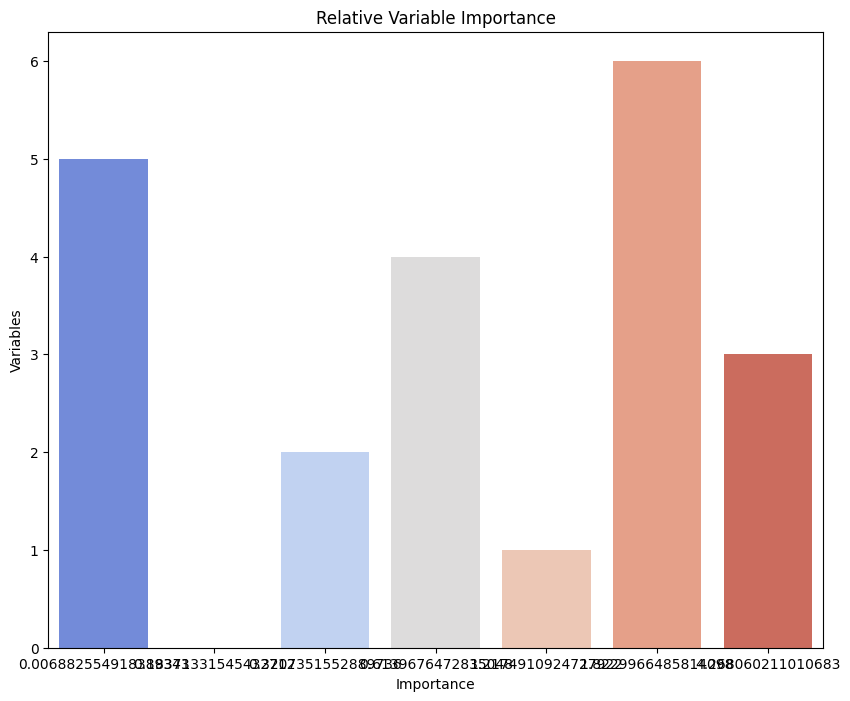

In [15]:
# Vẽ biểu đồ tầm quan trọng của biến
importance = rlm_results.params[1:]
variables = X_train.columns

importance_df = pd.DataFrame({
    'Variables': variables,
    'Importance': np.abs(importance)
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Variables', palette='coolwarm')
plt.title('Relative Variable Importance')
plt.show()


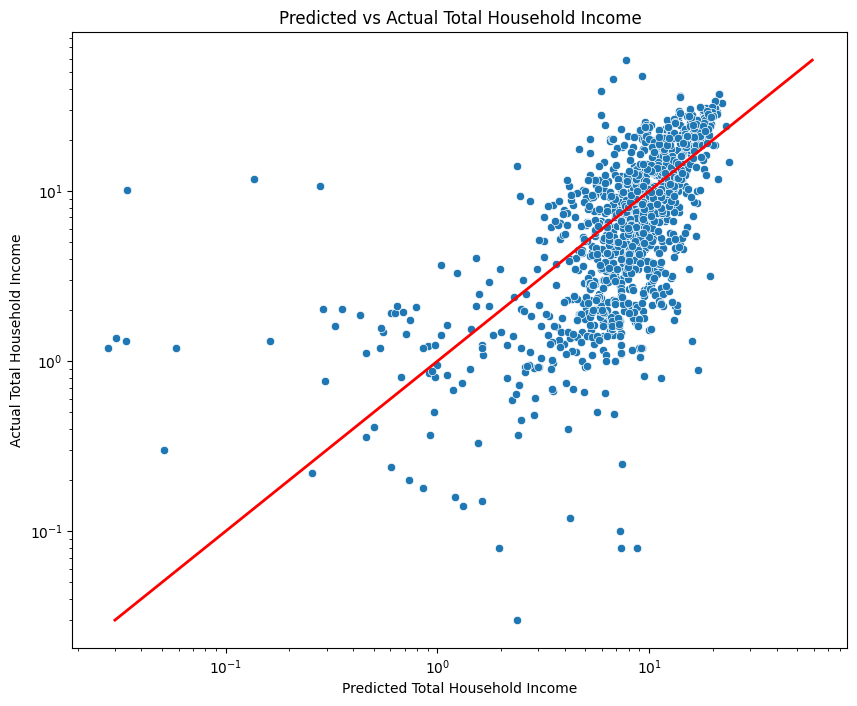

In [16]:
# Vẽ biểu đồ dự đoán so với giá trị thực tế
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_pred, y=y_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Predicted Total Household Income')
plt.ylabel('Actual Total Household Income')
plt.title('Predicted vs Actual Total Household Income')
plt.show()